# Transfer Learning!

Import all the things!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Bird Dataset

Our dataset is already stored in the folder `/kaggle/input/birds21wi`. We can set it up with torch as follows.

One thing to note, PyTorch will create internal class ids based on the ordering of classes in the folder (in alphabetical, not numerical order unfortunately). This means we have to create a backward mapping both to the original class ids and the class names.

In [2]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds21wi/birds/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds21wi/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open("/kaggle/input/birds21wi/birds/names.txt").read().strip().split("\n")
    
    # Backward mapping to original class ids (from folder names) and species name (from names.txt)
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

### Visualizing Bird Data

Just to make sure things make sense

torch.Size([8, 3, 224, 224])


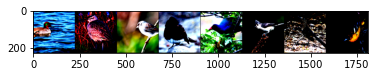

Labels:Green-winged Teal (Male),  Whimbrel, Dark-eyed Junco (Slate-colored), Black Phoebe, Purple Gallinule (Adult), Tufted Titmouse, Greater Roadrunner, Baltimore Oriole (Female/Immature male)


In [3]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

## Training Code

Same as previous transfer learning notebook...

In [3]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr/50, momentum=momentum, weight_decay=decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(dataloader), epochs=epochs, div_factor=50, final_div_factor=5000, verbose=verbose)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            scheduler.step()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

### Learning Rate Range Test

In [4]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [5]:
def plot_lr_range_test(net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.0005)
    lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
    lr_finder.range_test(data['train'], end_lr=10, num_iter=100, diverge_th=7)
    lr_finder.plot()
    lr_finder.reset()

### Training DenseNet

Use PyTorch's pretrained DenseNet model. We change the last layer to fit our output size (555 classes) and train for 7 epochs.

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.43E+00


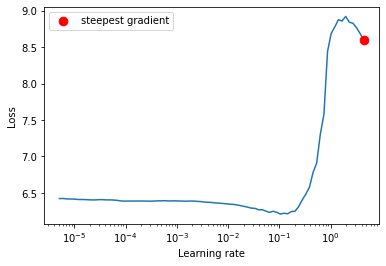

In [7]:
densenet = torchvision.models.densenet169(pretrained=True)
densenet.classifier = nn.Linear(1664, 555)
#print(densenet)

plot_lr_range_test(densenet)

In [8]:
densenet = torchvision.models.densenet169(pretrained=True)
densenet.classifier = nn.Linear(1664, 555)

losses = train(densenet, data['train'], epochs=10, lr=.05, print_every=10, checkpoint_path='./')

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0001e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0009e-03.
Adjusting learning rate of group 0 to 1.0013e-03.
Adjusting learning rate of group 0 to 1.0018e-03.
Adjusting learning rate of group 0 to 1.0024e-03.
Adjusting learning rate of group 0 to 1.0030e-03.
Adjusting learning rate of group 0 to 1.0037e-03.
[0,    10] loss: 6.382
Adjusting learning rate of group 0 to 1.0045e-03.
Adjusting learning rate of group 0 to 1.0053e-03.
Adjusting learning rate of group 0 to 1.0063e-03.
Adjusting learning rate of group 0 to 1.0072e-03.
Adjusting learning rate of group 0 to 1.0083e-03.
Adjusting learning rate of group 0 to 1.0095e-03.
Adjusting learning rate of group 0 to 1.0107e-03.
Adjusting learning rate of group 0 to 1.0120e-03.
Adjusting learning rate of 

Adjusting learning rate of group 0 to 1.9060e-03.
Adjusting learning rate of group 0 to 1.9175e-03.
Adjusting learning rate of group 0 to 1.9291e-03.
Adjusting learning rate of group 0 to 1.9408e-03.
[0,   160] loss: 5.369
Adjusting learning rate of group 0 to 1.9525e-03.
Adjusting learning rate of group 0 to 1.9643e-03.
Adjusting learning rate of group 0 to 1.9761e-03.
Adjusting learning rate of group 0 to 1.9881e-03.
Adjusting learning rate of group 0 to 2.0001e-03.
Adjusting learning rate of group 0 to 2.0121e-03.
Adjusting learning rate of group 0 to 2.0243e-03.
Adjusting learning rate of group 0 to 2.0365e-03.
Adjusting learning rate of group 0 to 2.0488e-03.
Adjusting learning rate of group 0 to 2.0611e-03.
[0,   170] loss: 5.325
Adjusting learning rate of group 0 to 2.0736e-03.
Adjusting learning rate of group 0 to 2.0861e-03.
Adjusting learning rate of group 0 to 2.0986e-03.
Adjusting learning rate of group 0 to 2.1113e-03.
Adjusting learning rate of group 0 to 2.1240e-03.
Adju

Adjusting learning rate of group 0 to 4.5571e-03.
Adjusting learning rate of group 0 to 4.5792e-03.
Adjusting learning rate of group 0 to 4.6014e-03.
Adjusting learning rate of group 0 to 4.6237e-03.
Adjusting learning rate of group 0 to 4.6460e-03.
Adjusting learning rate of group 0 to 4.6684e-03.
Adjusting learning rate of group 0 to 4.6908e-03.
[0,   320] loss: 3.417
Adjusting learning rate of group 0 to 4.7133e-03.
Adjusting learning rate of group 0 to 4.7359e-03.
Adjusting learning rate of group 0 to 4.7585e-03.
Adjusting learning rate of group 0 to 4.7812e-03.
Adjusting learning rate of group 0 to 4.8039e-03.
Adjusting learning rate of group 0 to 4.8267e-03.
Adjusting learning rate of group 0 to 4.8496e-03.
Adjusting learning rate of group 0 to 4.8726e-03.
Adjusting learning rate of group 0 to 4.8956e-03.
Adjusting learning rate of group 0 to 4.9186e-03.
[0,   330] loss: 3.494
Adjusting learning rate of group 0 to 4.9418e-03.
Adjusting learning rate of group 0 to 4.9649e-03.
Adju

Adjusting learning rate of group 0 to 8.7572e-03.
Adjusting learning rate of group 0 to 8.7883e-03.
Adjusting learning rate of group 0 to 8.8194e-03.
Adjusting learning rate of group 0 to 8.8506e-03.
Adjusting learning rate of group 0 to 8.8819e-03.
Adjusting learning rate of group 0 to 8.9132e-03.
Adjusting learning rate of group 0 to 8.9446e-03.
Adjusting learning rate of group 0 to 8.9760e-03.
Adjusting learning rate of group 0 to 9.0074e-03.
Adjusting learning rate of group 0 to 9.0389e-03.
[0,   480] loss: 2.522
Adjusting learning rate of group 0 to 9.0705e-03.
Adjusting learning rate of group 0 to 9.1021e-03.
Adjusting learning rate of group 0 to 9.1337e-03.
Adjusting learning rate of group 0 to 9.1654e-03.
Adjusting learning rate of group 0 to 9.1972e-03.
Adjusting learning rate of group 0 to 9.2290e-03.
Adjusting learning rate of group 0 to 9.2608e-03.
Adjusting learning rate of group 0 to 9.2928e-03.
Adjusting learning rate of group 0 to 9.3247e-03.
Adjusting learning rate of 

Adjusting learning rate of group 0 to 1.4196e-02.
Adjusting learning rate of group 0 to 1.4233e-02.
Adjusting learning rate of group 0 to 1.4271e-02.
Adjusting learning rate of group 0 to 1.4309e-02.
Adjusting learning rate of group 0 to 1.4347e-02.
Adjusting learning rate of group 0 to 1.4385e-02.
[1,    30] loss: 2.119
Adjusting learning rate of group 0 to 1.4423e-02.
Adjusting learning rate of group 0 to 1.4461e-02.
Adjusting learning rate of group 0 to 1.4499e-02.
Adjusting learning rate of group 0 to 1.4537e-02.
Adjusting learning rate of group 0 to 1.4575e-02.
Adjusting learning rate of group 0 to 1.4613e-02.
Adjusting learning rate of group 0 to 1.4651e-02.
Adjusting learning rate of group 0 to 1.4689e-02.
Adjusting learning rate of group 0 to 1.4728e-02.
Adjusting learning rate of group 0 to 1.4766e-02.
[1,    40] loss: 2.165
Adjusting learning rate of group 0 to 1.4804e-02.
Adjusting learning rate of group 0 to 1.4842e-02.
Adjusting learning rate of group 0 to 1.4881e-02.
Adju

Adjusting learning rate of group 0 to 2.0470e-02.
Adjusting learning rate of group 0 to 2.0512e-02.
Adjusting learning rate of group 0 to 2.0553e-02.
Adjusting learning rate of group 0 to 2.0595e-02.
Adjusting learning rate of group 0 to 2.0637e-02.
Adjusting learning rate of group 0 to 2.0679e-02.
Adjusting learning rate of group 0 to 2.0720e-02.
Adjusting learning rate of group 0 to 2.0762e-02.
Adjusting learning rate of group 0 to 2.0804e-02.
[1,   190] loss: 2.179
Adjusting learning rate of group 0 to 2.0846e-02.
Adjusting learning rate of group 0 to 2.0887e-02.
Adjusting learning rate of group 0 to 2.0929e-02.
Adjusting learning rate of group 0 to 2.0971e-02.
Adjusting learning rate of group 0 to 2.1013e-02.
Adjusting learning rate of group 0 to 2.1055e-02.
Adjusting learning rate of group 0 to 2.1097e-02.
Adjusting learning rate of group 0 to 2.1139e-02.
Adjusting learning rate of group 0 to 2.1180e-02.
Adjusting learning rate of group 0 to 2.1222e-02.
[1,   200] loss: 2.153
Adju

Adjusting learning rate of group 0 to 2.7117e-02.
Adjusting learning rate of group 0 to 2.7159e-02.
[1,   340] loss: 2.197
Adjusting learning rate of group 0 to 2.7201e-02.
Adjusting learning rate of group 0 to 2.7244e-02.
Adjusting learning rate of group 0 to 2.7286e-02.
Adjusting learning rate of group 0 to 2.7329e-02.
Adjusting learning rate of group 0 to 2.7371e-02.
Adjusting learning rate of group 0 to 2.7414e-02.
Adjusting learning rate of group 0 to 2.7456e-02.
Adjusting learning rate of group 0 to 2.7499e-02.
Adjusting learning rate of group 0 to 2.7541e-02.
Adjusting learning rate of group 0 to 2.7583e-02.
[1,   350] loss: 2.042
Adjusting learning rate of group 0 to 2.7626e-02.
Adjusting learning rate of group 0 to 2.7668e-02.
Adjusting learning rate of group 0 to 2.7711e-02.
Adjusting learning rate of group 0 to 2.7753e-02.
Adjusting learning rate of group 0 to 2.7795e-02.
Adjusting learning rate of group 0 to 2.7838e-02.
Adjusting learning rate of group 0 to 2.7880e-02.
Adju

Adjusting learning rate of group 0 to 3.3643e-02.
Adjusting learning rate of group 0 to 3.3684e-02.
Adjusting learning rate of group 0 to 3.3724e-02.
Adjusting learning rate of group 0 to 3.3764e-02.
Adjusting learning rate of group 0 to 3.3804e-02.
[1,   500] loss: 1.849
Adjusting learning rate of group 0 to 3.3844e-02.
Adjusting learning rate of group 0 to 3.3884e-02.
Adjusting learning rate of group 0 to 3.3924e-02.
Adjusting learning rate of group 0 to 3.3964e-02.
Adjusting learning rate of group 0 to 3.4004e-02.
Adjusting learning rate of group 0 to 3.4044e-02.
Adjusting learning rate of group 0 to 3.4084e-02.
Adjusting learning rate of group 0 to 3.4123e-02.
Adjusting learning rate of group 0 to 3.4163e-02.
Adjusting learning rate of group 0 to 3.4203e-02.
[1,   510] loss: 1.934
Adjusting learning rate of group 0 to 3.4243e-02.
Adjusting learning rate of group 0 to 3.4283e-02.
Adjusting learning rate of group 0 to 3.4322e-02.
Adjusting learning rate of group 0 to 3.4362e-02.
Adju

Adjusting learning rate of group 0 to 3.9568e-02.
[2,    50] loss: 1.611
Adjusting learning rate of group 0 to 3.9603e-02.
Adjusting learning rate of group 0 to 3.9638e-02.
Adjusting learning rate of group 0 to 3.9672e-02.
Adjusting learning rate of group 0 to 3.9707e-02.
Adjusting learning rate of group 0 to 3.9742e-02.
Adjusting learning rate of group 0 to 3.9776e-02.
Adjusting learning rate of group 0 to 3.9811e-02.
Adjusting learning rate of group 0 to 3.9846e-02.
Adjusting learning rate of group 0 to 3.9880e-02.
Adjusting learning rate of group 0 to 3.9915e-02.
[2,    60] loss: 1.660
Adjusting learning rate of group 0 to 3.9949e-02.
Adjusting learning rate of group 0 to 3.9983e-02.
Adjusting learning rate of group 0 to 4.0018e-02.
Adjusting learning rate of group 0 to 4.0052e-02.
Adjusting learning rate of group 0 to 4.0086e-02.
Adjusting learning rate of group 0 to 4.0120e-02.
Adjusting learning rate of group 0 to 4.0154e-02.
Adjusting learning rate of group 0 to 4.0188e-02.
Adju

Adjusting learning rate of group 0 to 4.4452e-02.
Adjusting learning rate of group 0 to 4.4479e-02.
Adjusting learning rate of group 0 to 4.4506e-02.
Adjusting learning rate of group 0 to 4.4533e-02.
[2,   210] loss: 1.820
Adjusting learning rate of group 0 to 4.4560e-02.
Adjusting learning rate of group 0 to 4.4586e-02.
Adjusting learning rate of group 0 to 4.4613e-02.
Adjusting learning rate of group 0 to 4.4640e-02.
Adjusting learning rate of group 0 to 4.4666e-02.
Adjusting learning rate of group 0 to 4.4693e-02.
Adjusting learning rate of group 0 to 4.4719e-02.
Adjusting learning rate of group 0 to 4.4746e-02.
Adjusting learning rate of group 0 to 4.4772e-02.
Adjusting learning rate of group 0 to 4.4798e-02.
[2,   220] loss: 1.871
Adjusting learning rate of group 0 to 4.4824e-02.
Adjusting learning rate of group 0 to 4.4850e-02.
Adjusting learning rate of group 0 to 4.4877e-02.
Adjusting learning rate of group 0 to 4.4903e-02.
Adjusting learning rate of group 0 to 4.4929e-02.
Adju

Adjusting learning rate of group 0 to 4.7935e-02.
Adjusting learning rate of group 0 to 4.7952e-02.
Adjusting learning rate of group 0 to 4.7969e-02.
Adjusting learning rate of group 0 to 4.7986e-02.
Adjusting learning rate of group 0 to 4.8003e-02.
Adjusting learning rate of group 0 to 4.8019e-02.
Adjusting learning rate of group 0 to 4.8036e-02.
[2,   370] loss: 1.671
Adjusting learning rate of group 0 to 4.8053e-02.
Adjusting learning rate of group 0 to 4.8069e-02.
Adjusting learning rate of group 0 to 4.8086e-02.
Adjusting learning rate of group 0 to 4.8102e-02.
Adjusting learning rate of group 0 to 4.8119e-02.
Adjusting learning rate of group 0 to 4.8135e-02.
Adjusting learning rate of group 0 to 4.8151e-02.
Adjusting learning rate of group 0 to 4.8167e-02.
Adjusting learning rate of group 0 to 4.8184e-02.
Adjusting learning rate of group 0 to 4.8200e-02.
[2,   380] loss: 1.703
Adjusting learning rate of group 0 to 4.8216e-02.
Adjusting learning rate of group 0 to 4.8232e-02.
Adju

Adjusting learning rate of group 0 to 4.9758e-02.
Adjusting learning rate of group 0 to 4.9764e-02.
Adjusting learning rate of group 0 to 4.9770e-02.
Adjusting learning rate of group 0 to 4.9775e-02.
Adjusting learning rate of group 0 to 4.9781e-02.
Adjusting learning rate of group 0 to 4.9787e-02.
Adjusting learning rate of group 0 to 4.9792e-02.
Adjusting learning rate of group 0 to 4.9798e-02.
Adjusting learning rate of group 0 to 4.9803e-02.
Adjusting learning rate of group 0 to 4.9809e-02.
[2,   530] loss: 1.565
Adjusting learning rate of group 0 to 4.9814e-02.
Adjusting learning rate of group 0 to 4.9819e-02.
Adjusting learning rate of group 0 to 4.9824e-02.
Adjusting learning rate of group 0 to 4.9829e-02.
Adjusting learning rate of group 0 to 4.9834e-02.
Adjusting learning rate of group 0 to 4.9839e-02.
Adjusting learning rate of group 0 to 4.9844e-02.
Adjusting learning rate of group 0 to 4.9849e-02.
Adjusting learning rate of group 0 to 4.9853e-02.
Adjusting learning rate of 

Adjusting learning rate of group 0 to 4.9960e-02.
Adjusting learning rate of group 0 to 4.9959e-02.
Adjusting learning rate of group 0 to 4.9958e-02.
Adjusting learning rate of group 0 to 4.9957e-02.
Adjusting learning rate of group 0 to 4.9956e-02.
Adjusting learning rate of group 0 to 4.9955e-02.
[3,    80] loss: 1.320
Adjusting learning rate of group 0 to 4.9953e-02.
Adjusting learning rate of group 0 to 4.9952e-02.
Adjusting learning rate of group 0 to 4.9951e-02.
Adjusting learning rate of group 0 to 4.9950e-02.
Adjusting learning rate of group 0 to 4.9949e-02.
Adjusting learning rate of group 0 to 4.9948e-02.
Adjusting learning rate of group 0 to 4.9946e-02.
Adjusting learning rate of group 0 to 4.9945e-02.
Adjusting learning rate of group 0 to 4.9944e-02.
Adjusting learning rate of group 0 to 4.9943e-02.
[3,    90] loss: 1.200
Adjusting learning rate of group 0 to 4.9941e-02.
Adjusting learning rate of group 0 to 4.9940e-02.
Adjusting learning rate of group 0 to 4.9939e-02.
Adju

Adjusting learning rate of group 0 to 4.9625e-02.
Adjusting learning rate of group 0 to 4.9622e-02.
Adjusting learning rate of group 0 to 4.9619e-02.
Adjusting learning rate of group 0 to 4.9615e-02.
Adjusting learning rate of group 0 to 4.9612e-02.
Adjusting learning rate of group 0 to 4.9609e-02.
Adjusting learning rate of group 0 to 4.9606e-02.
Adjusting learning rate of group 0 to 4.9602e-02.
Adjusting learning rate of group 0 to 4.9599e-02.
[3,   240] loss: 1.300
Adjusting learning rate of group 0 to 4.9596e-02.
Adjusting learning rate of group 0 to 4.9592e-02.
Adjusting learning rate of group 0 to 4.9589e-02.
Adjusting learning rate of group 0 to 4.9586e-02.
Adjusting learning rate of group 0 to 4.9582e-02.
Adjusting learning rate of group 0 to 4.9579e-02.
Adjusting learning rate of group 0 to 4.9575e-02.
Adjusting learning rate of group 0 to 4.9572e-02.
Adjusting learning rate of group 0 to 4.9568e-02.
Adjusting learning rate of group 0 to 4.9565e-02.
[3,   250] loss: 1.325
Adju

Adjusting learning rate of group 0 to 4.8954e-02.
Adjusting learning rate of group 0 to 4.8949e-02.
[3,   390] loss: 1.197
Adjusting learning rate of group 0 to 4.8944e-02.
Adjusting learning rate of group 0 to 4.8938e-02.
Adjusting learning rate of group 0 to 4.8933e-02.
Adjusting learning rate of group 0 to 4.8927e-02.
Adjusting learning rate of group 0 to 4.8922e-02.
Adjusting learning rate of group 0 to 4.8917e-02.
Adjusting learning rate of group 0 to 4.8911e-02.
Adjusting learning rate of group 0 to 4.8906e-02.
Adjusting learning rate of group 0 to 4.8900e-02.
Adjusting learning rate of group 0 to 4.8895e-02.
[3,   400] loss: 1.182
Adjusting learning rate of group 0 to 4.8889e-02.
Adjusting learning rate of group 0 to 4.8884e-02.
Adjusting learning rate of group 0 to 4.8878e-02.
Adjusting learning rate of group 0 to 4.8873e-02.
Adjusting learning rate of group 0 to 4.8867e-02.
Adjusting learning rate of group 0 to 4.8862e-02.
Adjusting learning rate of group 0 to 4.8856e-02.
Adju

Adjusting learning rate of group 0 to 4.7957e-02.
Adjusting learning rate of group 0 to 4.7949e-02.
Adjusting learning rate of group 0 to 4.7942e-02.
Adjusting learning rate of group 0 to 4.7934e-02.
Adjusting learning rate of group 0 to 4.7927e-02.
[3,   550] loss: 1.289
Adjusting learning rate of group 0 to 4.7920e-02.
Adjusting learning rate of group 0 to 4.7912e-02.
Adjusting learning rate of group 0 to 4.7905e-02.
Adjusting learning rate of group 0 to 4.7897e-02.
Adjusting learning rate of group 0 to 4.7890e-02.
Adjusting learning rate of group 0 to 4.7882e-02.
Adjusting learning rate of group 0 to 4.7875e-02.
Adjusting learning rate of group 0 to 4.7867e-02.
Adjusting learning rate of group 0 to 4.7860e-02.
Adjusting learning rate of group 0 to 4.7852e-02.
[3,   560] loss: 1.169
Adjusting learning rate of group 0 to 4.7845e-02.
Adjusting learning rate of group 0 to 4.7837e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.7822e-02.
Adju

Adjusting learning rate of group 0 to 4.6646e-02.
[4,   100] loss: 1.094
Adjusting learning rate of group 0 to 4.6637e-02.
Adjusting learning rate of group 0 to 4.6627e-02.
Adjusting learning rate of group 0 to 4.6618e-02.
Adjusting learning rate of group 0 to 4.6609e-02.
Adjusting learning rate of group 0 to 4.6599e-02.
Adjusting learning rate of group 0 to 4.6590e-02.
Adjusting learning rate of group 0 to 4.6581e-02.
Adjusting learning rate of group 0 to 4.6571e-02.
Adjusting learning rate of group 0 to 4.6562e-02.
Adjusting learning rate of group 0 to 4.6552e-02.
[4,   110] loss: 1.035
Adjusting learning rate of group 0 to 4.6543e-02.
Adjusting learning rate of group 0 to 4.6533e-02.
Adjusting learning rate of group 0 to 4.6524e-02.
Adjusting learning rate of group 0 to 4.6514e-02.
Adjusting learning rate of group 0 to 4.6505e-02.
Adjusting learning rate of group 0 to 4.6496e-02.
Adjusting learning rate of group 0 to 4.6486e-02.
Adjusting learning rate of group 0 to 4.6476e-02.
Adju

Adjusting learning rate of group 0 to 4.5040e-02.
Adjusting learning rate of group 0 to 4.5029e-02.
Adjusting learning rate of group 0 to 4.5018e-02.
Adjusting learning rate of group 0 to 4.5007e-02.
[4,   260] loss: 1.044
Adjusting learning rate of group 0 to 4.4996e-02.
Adjusting learning rate of group 0 to 4.4984e-02.
Adjusting learning rate of group 0 to 4.4973e-02.
Adjusting learning rate of group 0 to 4.4962e-02.
Adjusting learning rate of group 0 to 4.4951e-02.
Adjusting learning rate of group 0 to 4.4940e-02.
Adjusting learning rate of group 0 to 4.4928e-02.
Adjusting learning rate of group 0 to 4.4917e-02.
Adjusting learning rate of group 0 to 4.4906e-02.
Adjusting learning rate of group 0 to 4.4895e-02.
[4,   270] loss: 1.098
Adjusting learning rate of group 0 to 4.4883e-02.
Adjusting learning rate of group 0 to 4.4872e-02.
Adjusting learning rate of group 0 to 4.4861e-02.
Adjusting learning rate of group 0 to 4.4849e-02.
Adjusting learning rate of group 0 to 4.4838e-02.
Adju

Adjusting learning rate of group 0 to 4.3161e-02.
Adjusting learning rate of group 0 to 4.3148e-02.
Adjusting learning rate of group 0 to 4.3135e-02.
Adjusting learning rate of group 0 to 4.3123e-02.
Adjusting learning rate of group 0 to 4.3110e-02.
Adjusting learning rate of group 0 to 4.3097e-02.
Adjusting learning rate of group 0 to 4.3084e-02.
[4,   420] loss: 1.120
Adjusting learning rate of group 0 to 4.3071e-02.
Adjusting learning rate of group 0 to 4.3058e-02.
Adjusting learning rate of group 0 to 4.3045e-02.
Adjusting learning rate of group 0 to 4.3033e-02.
Adjusting learning rate of group 0 to 4.3020e-02.
Adjusting learning rate of group 0 to 4.3007e-02.
Adjusting learning rate of group 0 to 4.2994e-02.
Adjusting learning rate of group 0 to 4.2981e-02.
Adjusting learning rate of group 0 to 4.2968e-02.
Adjusting learning rate of group 0 to 4.2955e-02.
[4,   430] loss: 1.037
Adjusting learning rate of group 0 to 4.2942e-02.
Adjusting learning rate of group 0 to 4.2929e-02.
Adju

Adjusting learning rate of group 0 to 4.1034e-02.
Adjusting learning rate of group 0 to 4.1020e-02.
Adjusting learning rate of group 0 to 4.1005e-02.
Adjusting learning rate of group 0 to 4.0991e-02.
Adjusting learning rate of group 0 to 4.0977e-02.
Adjusting learning rate of group 0 to 4.0963e-02.
Adjusting learning rate of group 0 to 4.0948e-02.
Adjusting learning rate of group 0 to 4.0934e-02.
Adjusting learning rate of group 0 to 4.0920e-02.
Adjusting learning rate of group 0 to 4.0905e-02.
[4,   580] loss: 1.119
Adjusting learning rate of group 0 to 4.0891e-02.
Adjusting learning rate of group 0 to 4.0876e-02.
Adjusting learning rate of group 0 to 4.0862e-02.
Adjusting learning rate of group 0 to 4.0848e-02.
Adjusting learning rate of group 0 to 4.0833e-02.
Adjusting learning rate of group 0 to 4.0819e-02.
Adjusting learning rate of group 0 to 4.0805e-02.
Adjusting learning rate of group 0 to 4.0790e-02.
Adjusting learning rate of group 0 to 4.0776e-02.
Adjusting learning rate of 

Adjusting learning rate of group 0 to 3.8689e-02.
Adjusting learning rate of group 0 to 3.8673e-02.
Adjusting learning rate of group 0 to 3.8657e-02.
Adjusting learning rate of group 0 to 3.8642e-02.
Adjusting learning rate of group 0 to 3.8626e-02.
Adjusting learning rate of group 0 to 3.8611e-02.
[5,   130] loss: 0.828
Adjusting learning rate of group 0 to 3.8595e-02.
Adjusting learning rate of group 0 to 3.8579e-02.
Adjusting learning rate of group 0 to 3.8564e-02.
Adjusting learning rate of group 0 to 3.8548e-02.
Adjusting learning rate of group 0 to 3.8532e-02.
Adjusting learning rate of group 0 to 3.8517e-02.
Adjusting learning rate of group 0 to 3.8501e-02.
Adjusting learning rate of group 0 to 3.8485e-02.
Adjusting learning rate of group 0 to 3.8470e-02.
Adjusting learning rate of group 0 to 3.8454e-02.
[5,   140] loss: 0.975
Adjusting learning rate of group 0 to 3.8438e-02.
Adjusting learning rate of group 0 to 3.8423e-02.
Adjusting learning rate of group 0 to 3.8407e-02.
Adju

Adjusting learning rate of group 0 to 3.6156e-02.
Adjusting learning rate of group 0 to 3.6140e-02.
Adjusting learning rate of group 0 to 3.6123e-02.
Adjusting learning rate of group 0 to 3.6106e-02.
Adjusting learning rate of group 0 to 3.6090e-02.
Adjusting learning rate of group 0 to 3.6073e-02.
Adjusting learning rate of group 0 to 3.6056e-02.
Adjusting learning rate of group 0 to 3.6040e-02.
Adjusting learning rate of group 0 to 3.6023e-02.
[5,   290] loss: 0.822
Adjusting learning rate of group 0 to 3.6006e-02.
Adjusting learning rate of group 0 to 3.5989e-02.
Adjusting learning rate of group 0 to 3.5973e-02.
Adjusting learning rate of group 0 to 3.5956e-02.
Adjusting learning rate of group 0 to 3.5939e-02.
Adjusting learning rate of group 0 to 3.5923e-02.
Adjusting learning rate of group 0 to 3.5906e-02.
Adjusting learning rate of group 0 to 3.5889e-02.
Adjusting learning rate of group 0 to 3.5872e-02.
Adjusting learning rate of group 0 to 3.5856e-02.
[5,   300] loss: 0.800
Adju

Adjusting learning rate of group 0 to 3.3472e-02.
Adjusting learning rate of group 0 to 3.3454e-02.
[5,   440] loss: 0.783
Adjusting learning rate of group 0 to 3.3437e-02.
Adjusting learning rate of group 0 to 3.3419e-02.
Adjusting learning rate of group 0 to 3.3402e-02.
Adjusting learning rate of group 0 to 3.3384e-02.
Adjusting learning rate of group 0 to 3.3367e-02.
Adjusting learning rate of group 0 to 3.3349e-02.
Adjusting learning rate of group 0 to 3.3332e-02.
Adjusting learning rate of group 0 to 3.3314e-02.
Adjusting learning rate of group 0 to 3.3297e-02.
Adjusting learning rate of group 0 to 3.3279e-02.
[5,   450] loss: 0.891
Adjusting learning rate of group 0 to 3.3261e-02.
Adjusting learning rate of group 0 to 3.3244e-02.
Adjusting learning rate of group 0 to 3.3226e-02.
Adjusting learning rate of group 0 to 3.3209e-02.
Adjusting learning rate of group 0 to 3.3191e-02.
Adjusting learning rate of group 0 to 3.3174e-02.
Adjusting learning rate of group 0 to 3.3156e-02.
Adju

Adjusting learning rate of group 0 to 3.0672e-02.
Adjusting learning rate of group 0 to 3.0654e-02.
Adjusting learning rate of group 0 to 3.0636e-02.
Adjusting learning rate of group 0 to 3.0618e-02.
Adjusting learning rate of group 0 to 3.0599e-02.
[5,   600] loss: 0.899
Adjusting learning rate of group 0 to 3.0581e-02.
Adjusting learning rate of group 0 to 3.0563e-02.
Adjusting learning rate of group 0 to 3.0545e-02.
Adjusting learning rate of group 0 to 3.0527e-02.
Adjusting learning rate of group 0 to 3.0509e-02.
Adjusting learning rate of group 0 to 3.0491e-02.
Adjusting learning rate of group 0 to 3.0472e-02.
Adjusting learning rate of group 0 to 3.0454e-02.
Adjusting learning rate of group 0 to 3.0436e-02.
Adjusting learning rate of group 0 to 3.0418e-02.
Adjusting learning rate of group 0 to 3.0400e-02.
Adjusting learning rate of group 0 to 3.0382e-02.
Adjusting learning rate of group 0 to 3.0363e-02.
[6,    10] loss: 0.698
Adjusting learning rate of group 0 to 3.0345e-02.
Adju

Adjusting learning rate of group 0 to 2.7795e-02.
[6,   150] loss: 0.701
Adjusting learning rate of group 0 to 2.7776e-02.
Adjusting learning rate of group 0 to 2.7758e-02.
Adjusting learning rate of group 0 to 2.7739e-02.
Adjusting learning rate of group 0 to 2.7721e-02.
Adjusting learning rate of group 0 to 2.7702e-02.
Adjusting learning rate of group 0 to 2.7684e-02.
Adjusting learning rate of group 0 to 2.7665e-02.
Adjusting learning rate of group 0 to 2.7647e-02.
Adjusting learning rate of group 0 to 2.7628e-02.
Adjusting learning rate of group 0 to 2.7610e-02.
[6,   160] loss: 0.682
Adjusting learning rate of group 0 to 2.7591e-02.
Adjusting learning rate of group 0 to 2.7573e-02.
Adjusting learning rate of group 0 to 2.7554e-02.
Adjusting learning rate of group 0 to 2.7536e-02.
Adjusting learning rate of group 0 to 2.7517e-02.
Adjusting learning rate of group 0 to 2.7499e-02.
Adjusting learning rate of group 0 to 2.7480e-02.
Adjusting learning rate of group 0 to 2.7462e-02.
Adju

Adjusting learning rate of group 0 to 2.4879e-02.
Adjusting learning rate of group 0 to 2.4861e-02.
Adjusting learning rate of group 0 to 2.4842e-02.
Adjusting learning rate of group 0 to 2.4823e-02.
[6,   310] loss: 0.620
Adjusting learning rate of group 0 to 2.4805e-02.
Adjusting learning rate of group 0 to 2.4786e-02.
Adjusting learning rate of group 0 to 2.4768e-02.
Adjusting learning rate of group 0 to 2.4749e-02.
Adjusting learning rate of group 0 to 2.4730e-02.
Adjusting learning rate of group 0 to 2.4712e-02.
Adjusting learning rate of group 0 to 2.4693e-02.
Adjusting learning rate of group 0 to 2.4674e-02.
Adjusting learning rate of group 0 to 2.4656e-02.
Adjusting learning rate of group 0 to 2.4637e-02.
[6,   320] loss: 0.692
Adjusting learning rate of group 0 to 2.4619e-02.
Adjusting learning rate of group 0 to 2.4600e-02.
Adjusting learning rate of group 0 to 2.4581e-02.
Adjusting learning rate of group 0 to 2.4563e-02.
Adjusting learning rate of group 0 to 2.4544e-02.
Adju

Adjusting learning rate of group 0 to 2.1965e-02.
Adjusting learning rate of group 0 to 2.1947e-02.
Adjusting learning rate of group 0 to 2.1928e-02.
Adjusting learning rate of group 0 to 2.1910e-02.
Adjusting learning rate of group 0 to 2.1892e-02.
Adjusting learning rate of group 0 to 2.1873e-02.
Adjusting learning rate of group 0 to 2.1855e-02.
[6,   470] loss: 0.665
Adjusting learning rate of group 0 to 2.1836e-02.
Adjusting learning rate of group 0 to 2.1818e-02.
Adjusting learning rate of group 0 to 2.1799e-02.
Adjusting learning rate of group 0 to 2.1781e-02.
Adjusting learning rate of group 0 to 2.1762e-02.
Adjusting learning rate of group 0 to 2.1744e-02.
Adjusting learning rate of group 0 to 2.1725e-02.
Adjusting learning rate of group 0 to 2.1707e-02.
Adjusting learning rate of group 0 to 2.1689e-02.
Adjusting learning rate of group 0 to 2.1670e-02.
[6,   480] loss: 0.739
Adjusting learning rate of group 0 to 2.1652e-02.
Adjusting learning rate of group 0 to 2.1633e-02.
Adju

Adjusting learning rate of group 0 to 1.9093e-02.
Adjusting learning rate of group 0 to 1.9075e-02.
Adjusting learning rate of group 0 to 1.9057e-02.
[7,    20] loss: 0.524
Adjusting learning rate of group 0 to 1.9039e-02.
Adjusting learning rate of group 0 to 1.9021e-02.
Adjusting learning rate of group 0 to 1.9003e-02.
Adjusting learning rate of group 0 to 1.8985e-02.
Adjusting learning rate of group 0 to 1.8967e-02.
Adjusting learning rate of group 0 to 1.8948e-02.
Adjusting learning rate of group 0 to 1.8930e-02.
Adjusting learning rate of group 0 to 1.8912e-02.
Adjusting learning rate of group 0 to 1.8894e-02.
Adjusting learning rate of group 0 to 1.8876e-02.
[7,    30] loss: 0.512
Adjusting learning rate of group 0 to 1.8858e-02.
Adjusting learning rate of group 0 to 1.8840e-02.
Adjusting learning rate of group 0 to 1.8822e-02.
Adjusting learning rate of group 0 to 1.8804e-02.
Adjusting learning rate of group 0 to 1.8786e-02.
Adjusting learning rate of group 0 to 1.8768e-02.
Adju

Adjusting learning rate of group 0 to 1.6301e-02.
Adjusting learning rate of group 0 to 1.6284e-02.
Adjusting learning rate of group 0 to 1.6266e-02.
Adjusting learning rate of group 0 to 1.6249e-02.
Adjusting learning rate of group 0 to 1.6231e-02.
Adjusting learning rate of group 0 to 1.6214e-02.
[7,   180] loss: 0.514
Adjusting learning rate of group 0 to 1.6197e-02.
Adjusting learning rate of group 0 to 1.6179e-02.
Adjusting learning rate of group 0 to 1.6162e-02.
Adjusting learning rate of group 0 to 1.6144e-02.
Adjusting learning rate of group 0 to 1.6127e-02.
Adjusting learning rate of group 0 to 1.6110e-02.
Adjusting learning rate of group 0 to 1.6092e-02.
Adjusting learning rate of group 0 to 1.6075e-02.
Adjusting learning rate of group 0 to 1.6057e-02.
Adjusting learning rate of group 0 to 1.6040e-02.
[7,   190] loss: 0.480
Adjusting learning rate of group 0 to 1.6023e-02.
Adjusting learning rate of group 0 to 1.6005e-02.
Adjusting learning rate of group 0 to 1.5988e-02.
Adju

Adjusting learning rate of group 0 to 1.3628e-02.
Adjusting learning rate of group 0 to 1.3611e-02.
Adjusting learning rate of group 0 to 1.3595e-02.
Adjusting learning rate of group 0 to 1.3578e-02.
Adjusting learning rate of group 0 to 1.3562e-02.
Adjusting learning rate of group 0 to 1.3545e-02.
Adjusting learning rate of group 0 to 1.3529e-02.
Adjusting learning rate of group 0 to 1.3512e-02.
Adjusting learning rate of group 0 to 1.3496e-02.
[7,   340] loss: 0.418
Adjusting learning rate of group 0 to 1.3479e-02.
Adjusting learning rate of group 0 to 1.3463e-02.
Adjusting learning rate of group 0 to 1.3446e-02.
Adjusting learning rate of group 0 to 1.3430e-02.
Adjusting learning rate of group 0 to 1.3413e-02.
Adjusting learning rate of group 0 to 1.3397e-02.
Adjusting learning rate of group 0 to 1.3380e-02.
Adjusting learning rate of group 0 to 1.3364e-02.
Adjusting learning rate of group 0 to 1.3347e-02.
Adjusting learning rate of group 0 to 1.3331e-02.
[7,   350] loss: 0.516
Adju

Adjusting learning rate of group 0 to 1.1110e-02.
Adjusting learning rate of group 0 to 1.1094e-02.
[7,   490] loss: 0.416
Adjusting learning rate of group 0 to 1.1079e-02.
Adjusting learning rate of group 0 to 1.1064e-02.
Adjusting learning rate of group 0 to 1.1048e-02.
Adjusting learning rate of group 0 to 1.1033e-02.
Adjusting learning rate of group 0 to 1.1017e-02.
Adjusting learning rate of group 0 to 1.1002e-02.
Adjusting learning rate of group 0 to 1.0986e-02.
Adjusting learning rate of group 0 to 1.0971e-02.
Adjusting learning rate of group 0 to 1.0956e-02.
Adjusting learning rate of group 0 to 1.0940e-02.
[7,   500] loss: 0.482
Adjusting learning rate of group 0 to 1.0925e-02.
Adjusting learning rate of group 0 to 1.0909e-02.
Adjusting learning rate of group 0 to 1.0894e-02.
Adjusting learning rate of group 0 to 1.0879e-02.
Adjusting learning rate of group 0 to 1.0863e-02.
Adjusting learning rate of group 0 to 1.0848e-02.
Adjusting learning rate of group 0 to 1.0833e-02.
Adju

Adjusting learning rate of group 0 to 8.7813e-03.
Adjusting learning rate of group 0 to 8.7671e-03.
Adjusting learning rate of group 0 to 8.7530e-03.
Adjusting learning rate of group 0 to 8.7389e-03.
Adjusting learning rate of group 0 to 8.7247e-03.
Adjusting learning rate of group 0 to 8.7106e-03.
Adjusting learning rate of group 0 to 8.6965e-03.
Adjusting learning rate of group 0 to 8.6824e-03.
[8,    50] loss: 0.353
Adjusting learning rate of group 0 to 8.6683e-03.
Adjusting learning rate of group 0 to 8.6542e-03.
Adjusting learning rate of group 0 to 8.6402e-03.
Adjusting learning rate of group 0 to 8.6261e-03.
Adjusting learning rate of group 0 to 8.6120e-03.
Adjusting learning rate of group 0 to 8.5980e-03.
Adjusting learning rate of group 0 to 8.5839e-03.
Adjusting learning rate of group 0 to 8.5699e-03.
Adjusting learning rate of group 0 to 8.5559e-03.
Adjusting learning rate of group 0 to 8.5419e-03.
[8,    60] loss: 0.315
Adjusting learning rate of group 0 to 8.5279e-03.
Adju

Adjusting learning rate of group 0 to 6.6739e-03.
[8,   200] loss: 0.279
Adjusting learning rate of group 0 to 6.6612e-03.
Adjusting learning rate of group 0 to 6.6486e-03.
Adjusting learning rate of group 0 to 6.6360e-03.
Adjusting learning rate of group 0 to 6.6233e-03.
Adjusting learning rate of group 0 to 6.6107e-03.
Adjusting learning rate of group 0 to 6.5981e-03.
Adjusting learning rate of group 0 to 6.5855e-03.
Adjusting learning rate of group 0 to 6.5730e-03.
Adjusting learning rate of group 0 to 6.5604e-03.
Adjusting learning rate of group 0 to 6.5478e-03.
[8,   210] loss: 0.320
Adjusting learning rate of group 0 to 6.5353e-03.
Adjusting learning rate of group 0 to 6.5227e-03.
Adjusting learning rate of group 0 to 6.5102e-03.
Adjusting learning rate of group 0 to 6.4977e-03.
Adjusting learning rate of group 0 to 6.4852e-03.
Adjusting learning rate of group 0 to 6.4727e-03.
Adjusting learning rate of group 0 to 6.4602e-03.
Adjusting learning rate of group 0 to 6.4477e-03.
Adju

Adjusting learning rate of group 0 to 4.8164e-03.
Adjusting learning rate of group 0 to 4.8054e-03.
Adjusting learning rate of group 0 to 4.7945e-03.
Adjusting learning rate of group 0 to 4.7835e-03.
[8,   360] loss: 0.290
Adjusting learning rate of group 0 to 4.7726e-03.
Adjusting learning rate of group 0 to 4.7616e-03.
Adjusting learning rate of group 0 to 4.7507e-03.
Adjusting learning rate of group 0 to 4.7398e-03.
Adjusting learning rate of group 0 to 4.7289e-03.
Adjusting learning rate of group 0 to 4.7180e-03.
Adjusting learning rate of group 0 to 4.7072e-03.
Adjusting learning rate of group 0 to 4.6963e-03.
Adjusting learning rate of group 0 to 4.6855e-03.
Adjusting learning rate of group 0 to 4.6746e-03.
[8,   370] loss: 0.289
Adjusting learning rate of group 0 to 4.6638e-03.
Adjusting learning rate of group 0 to 4.6530e-03.
Adjusting learning rate of group 0 to 4.6422e-03.
Adjusting learning rate of group 0 to 4.6314e-03.
Adjusting learning rate of group 0 to 4.6206e-03.
Adju

Adjusting learning rate of group 0 to 3.2342e-03.
Adjusting learning rate of group 0 to 3.2251e-03.
Adjusting learning rate of group 0 to 3.2159e-03.
Adjusting learning rate of group 0 to 3.2068e-03.
Adjusting learning rate of group 0 to 3.1977e-03.
Adjusting learning rate of group 0 to 3.1886e-03.
Adjusting learning rate of group 0 to 3.1795e-03.
[8,   520] loss: 0.267
Adjusting learning rate of group 0 to 3.1704e-03.
Adjusting learning rate of group 0 to 3.1614e-03.
Adjusting learning rate of group 0 to 3.1523e-03.
Adjusting learning rate of group 0 to 3.1433e-03.
Adjusting learning rate of group 0 to 3.1342e-03.
Adjusting learning rate of group 0 to 3.1252e-03.
Adjusting learning rate of group 0 to 3.1162e-03.
Adjusting learning rate of group 0 to 3.1072e-03.
Adjusting learning rate of group 0 to 3.0983e-03.
Adjusting learning rate of group 0 to 3.0893e-03.
[8,   530] loss: 0.245
Adjusting learning rate of group 0 to 3.0803e-03.
Adjusting learning rate of group 0 to 3.0714e-03.
Adju

Adjusting learning rate of group 0 to 1.9489e-03.
Adjusting learning rate of group 0 to 1.9417e-03.
Adjusting learning rate of group 0 to 1.9345e-03.
[9,    70] loss: 0.199
Adjusting learning rate of group 0 to 1.9273e-03.
Adjusting learning rate of group 0 to 1.9202e-03.
Adjusting learning rate of group 0 to 1.9130e-03.
Adjusting learning rate of group 0 to 1.9059e-03.
Adjusting learning rate of group 0 to 1.8988e-03.
Adjusting learning rate of group 0 to 1.8917e-03.
Adjusting learning rate of group 0 to 1.8846e-03.
Adjusting learning rate of group 0 to 1.8775e-03.
Adjusting learning rate of group 0 to 1.8704e-03.
Adjusting learning rate of group 0 to 1.8634e-03.
[9,    80] loss: 0.210
Adjusting learning rate of group 0 to 1.8563e-03.
Adjusting learning rate of group 0 to 1.8493e-03.
Adjusting learning rate of group 0 to 1.8423e-03.
Adjusting learning rate of group 0 to 1.8353e-03.
Adjusting learning rate of group 0 to 1.8283e-03.
Adjusting learning rate of group 0 to 1.8213e-03.
Adju

Adjusting learning rate of group 0 to 9.7791e-04.
Adjusting learning rate of group 0 to 9.7276e-04.
Adjusting learning rate of group 0 to 9.6763e-04.
Adjusting learning rate of group 0 to 9.6251e-04.
Adjusting learning rate of group 0 to 9.5740e-04.
Adjusting learning rate of group 0 to 9.5231e-04.
[9,   230] loss: 0.195
Adjusting learning rate of group 0 to 9.4723e-04.
Adjusting learning rate of group 0 to 9.4216e-04.
Adjusting learning rate of group 0 to 9.3711e-04.
Adjusting learning rate of group 0 to 9.3207e-04.
Adjusting learning rate of group 0 to 9.2705e-04.
Adjusting learning rate of group 0 to 9.2203e-04.
Adjusting learning rate of group 0 to 9.1703e-04.
Adjusting learning rate of group 0 to 9.1205e-04.
Adjusting learning rate of group 0 to 9.0707e-04.
Adjusting learning rate of group 0 to 9.0212e-04.
[9,   240] loss: 0.188
Adjusting learning rate of group 0 to 8.9717e-04.
Adjusting learning rate of group 0 to 8.9224e-04.
Adjusting learning rate of group 0 to 8.8732e-04.
Adju

Adjusting learning rate of group 0 to 3.3459e-04.
Adjusting learning rate of group 0 to 3.3156e-04.
Adjusting learning rate of group 0 to 3.2855e-04.
Adjusting learning rate of group 0 to 3.2555e-04.
Adjusting learning rate of group 0 to 3.2257e-04.
Adjusting learning rate of group 0 to 3.1959e-04.
Adjusting learning rate of group 0 to 3.1664e-04.
Adjusting learning rate of group 0 to 3.1369e-04.
Adjusting learning rate of group 0 to 3.1076e-04.
[9,   390] loss: 0.183
Adjusting learning rate of group 0 to 3.0784e-04.
Adjusting learning rate of group 0 to 3.0494e-04.
Adjusting learning rate of group 0 to 3.0205e-04.
Adjusting learning rate of group 0 to 2.9918e-04.
Adjusting learning rate of group 0 to 2.9631e-04.
Adjusting learning rate of group 0 to 2.9347e-04.
Adjusting learning rate of group 0 to 2.9063e-04.
Adjusting learning rate of group 0 to 2.8781e-04.
Adjusting learning rate of group 0 to 2.8500e-04.
Adjusting learning rate of group 0 to 2.8221e-04.
[9,   400] loss: 0.176
Adju

Adjusting learning rate of group 0 to 2.7678e-05.
Adjusting learning rate of group 0 to 2.6812e-05.
[9,   540] loss: 0.160
Adjusting learning rate of group 0 to 2.5961e-05.
Adjusting learning rate of group 0 to 2.5123e-05.
Adjusting learning rate of group 0 to 2.4300e-05.
Adjusting learning rate of group 0 to 2.3490e-05.
Adjusting learning rate of group 0 to 2.2694e-05.
Adjusting learning rate of group 0 to 2.1912e-05.
Adjusting learning rate of group 0 to 2.1143e-05.
Adjusting learning rate of group 0 to 2.0389e-05.
Adjusting learning rate of group 0 to 1.9648e-05.
Adjusting learning rate of group 0 to 1.8921e-05.
[9,   550] loss: 0.138
Adjusting learning rate of group 0 to 1.8208e-05.
Adjusting learning rate of group 0 to 1.7509e-05.
Adjusting learning rate of group 0 to 1.6823e-05.
Adjusting learning rate of group 0 to 1.6152e-05.
Adjusting learning rate of group 0 to 1.5494e-05.
Adjusting learning rate of group 0 to 1.4850e-05.
Adjusting learning rate of group 0 to 1.4220e-05.
Adju

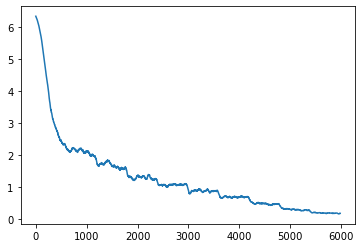

In [9]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses,50))

### Training EfficientNet

In [6]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=96d771f2a3dfca7284f5dbc248862d1d20e4de86b0a607b30b5672c610877a2b
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.39E-01


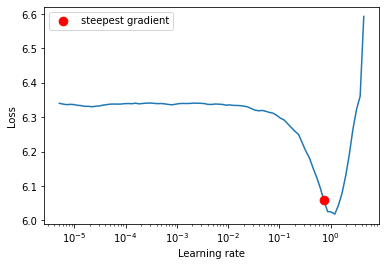

In [7]:
efficientnet = EfficientNet.from_pretrained('efficientnet-b4', num_classes=555)
#print(efficientnet)

plot_lr_range_test(efficientnet)

In [ ]:
losses = train(efficientnet, data['train'], epochs=10, lr=.4, print_every=10, checkpoint_path='./efficientnet/')

In [ ]:
plt.plot(smooth(losses,50))

## Make Our Predictions!

We'll predict for all 10,000 images in the test set. Remember we need to use our inverse mapping from to get back to the original class ids.

In [18]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

### Ensemble

In [5]:
def predict_ensemble(net1, net2, alpha, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs1 = net1(images)
            outputs2 = net2(images)
            outputs = outputs1*alpha + outputs2*(1-alpha)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

def compute_alpha(net1, net2):
    net1.to(device)
    net1.eval()
    net2.to(device)
    net2.eval()
    accuracies = []
    alphas = []
    
    for alpha in range(5, 96, 5):
        print(alpha)
        num_correct = 0
        total = 0
        for i, batch in enumerate(data['train'], 0):
            if i%100==0: print(i, end = ' ')
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs1 = net1(inputs)
            outputs2 = net2(inputs)
            outputs = outputs1*alpha/100 + outputs2*(1-alpha/100)
            _, pred = torch.max(outputs.data, 1)
            for p, l in zip(pred, labels):
                total += 1
                if p == l: num_correct += 1
            if i==999: break
        print()
        accuracies.append(num_correct / total)
        alphas.append(alpha/100)
    print(accuracies)
    print(alphas)
    return (alphas, accuracies)

In [6]:
cp1 = torch.load('../input/checkpoints/checkpoint-10-efficientnet.pkl')
net1 = EfficientNet.from_name('efficientnet-b4', num_classes=555)
net1.load_state_dict(cp1['net'])

cp2 = torch.load('../input/checkpoints/checkpoint-10-densenet.pkl')
net2 = torchvision.models.densenet169(pretrained=False)
net2.classifier = nn.Linear(1664, 555)
net2.load_state_dict(cp2['net'])

alphas, accuracies = compute_alpha(net1, net2)

5
0 100 200 300 400 500 600 700 800 900 
10
0 100 200 300 400 500 600 700 800 900 
15
0 100 200 300 400 500 600 700 800 900 
20
0 100 200 300 400 500 600 700 800 900 
25
0 100 200 300 400 500 600 700 800 900 
30
0 100 200 300 400 500 600 700 800 900 
35
0 100 200 300 400 500 600 700 800 900 
40
0 100 200 300 400 500 600 700 800 900 
45
0 100 200 300 400 500 600 700 800 900 
50
0 100 200 300 400 500 600 700 800 900 
55
0 100 200 300 400 500 600 700 800 900 
60
0 100 200 300 400 500 600 700 800 900 
65
0 100 200 300 400 500 600 700 800 900 
70
0 100 200 300 400 500 600 700 800 900 
75
0 100 200 300 400 500 600 700 800 900 
80
0 100 200 300 400 500 600 700 800 900 
85
0 100 200 300 400 500 600 700 800 900 
90
0 100 200 300 400 500 600 700 800 900 
95
0 100 200 300 400 500 600 700 800 900 
[0.9423125, 0.945875, 0.944125, 0.9490625, 0.9503125, 0.9470625, 0.947125, 0.947125, 0.9485, 0.94725, 0.947, 0.9421875, 0.940625, 0.94075, 0.934625, 0.9350625, 0.9270625, 0.9226875, 0.916625]
[0.05, 0.1,

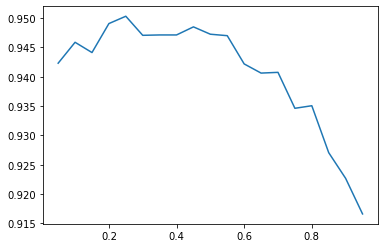

In [7]:
plt.plot(alphas, accuracies)

In [8]:
predict_ensemble(net1, net2, .45, data['test'], "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [28]:
predict(densenet, data['test'], "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
